# Data Preprocessing

In this project, I will be using python to explore and analyse an industry-like dataset provided by AiCore. The project has three main sections:
1. **Downloading the dataset from AWS RDS**. This part is not including in this notebook. It is executed directly on the db_utils.py file contained in the project's repository. The table is downloaded as a .csv and stored locally. This is then uploaded as a dataframe using pandas pd.read_csv built-in function.
2. **Data cleaning and pre-processing.**
3. **Data analysis and visualisation.**



In [1]:
# Import all required packages
from data_utils import DataTransform, DataFrameInfo, Plotter, StatisticalTests
from scipy.stats import chi2_contingency, normaltest
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

### **Initial Exploration**

First we will load the data and do some initial exploration

In [2]:
customer_activity_df = pd.read_csv('customer_activity.csv')
print(f"The shape of the DataFrame is: {customer_activity_df.shape}")
customer_activity_df.head()

The shape of the DataFrame is: (12330, 17)


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False


In [3]:
customer_activity_df.describe()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values
count,11760.000000,11418.000000,12330.000000,11994.000000,11751.000000,12129.000000,12330.000000,12330.000000,12330.000000
mean,2.308844,84.539079,0.497080,34.486687,32.814824,1192.426086,0.022381,0.042820,5.556310
std,3.364905,179.392485,1.174194,136.201557,44.597841,1767.243802,0.048847,0.048578,17.397345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,192.000000,0.000000,0.014000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,18.000000,586.000000,0.003500,0.025000,0.000000
75%,4.000000,95.000000,0.000000,0.000000,38.000000,1425.000000,0.017600,0.049000,0.000000
max,24.000000,2155.000000,12.000000,1988.750000,485.000000,23866.000000,0.200000,0.200000,254.600000


In [4]:
info_extractor = DataFrameInfo(customer_activity_df)
print(customer_activity_df.info())
print('\n', info_extractor.generate_null_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

<AxesSubplot: >

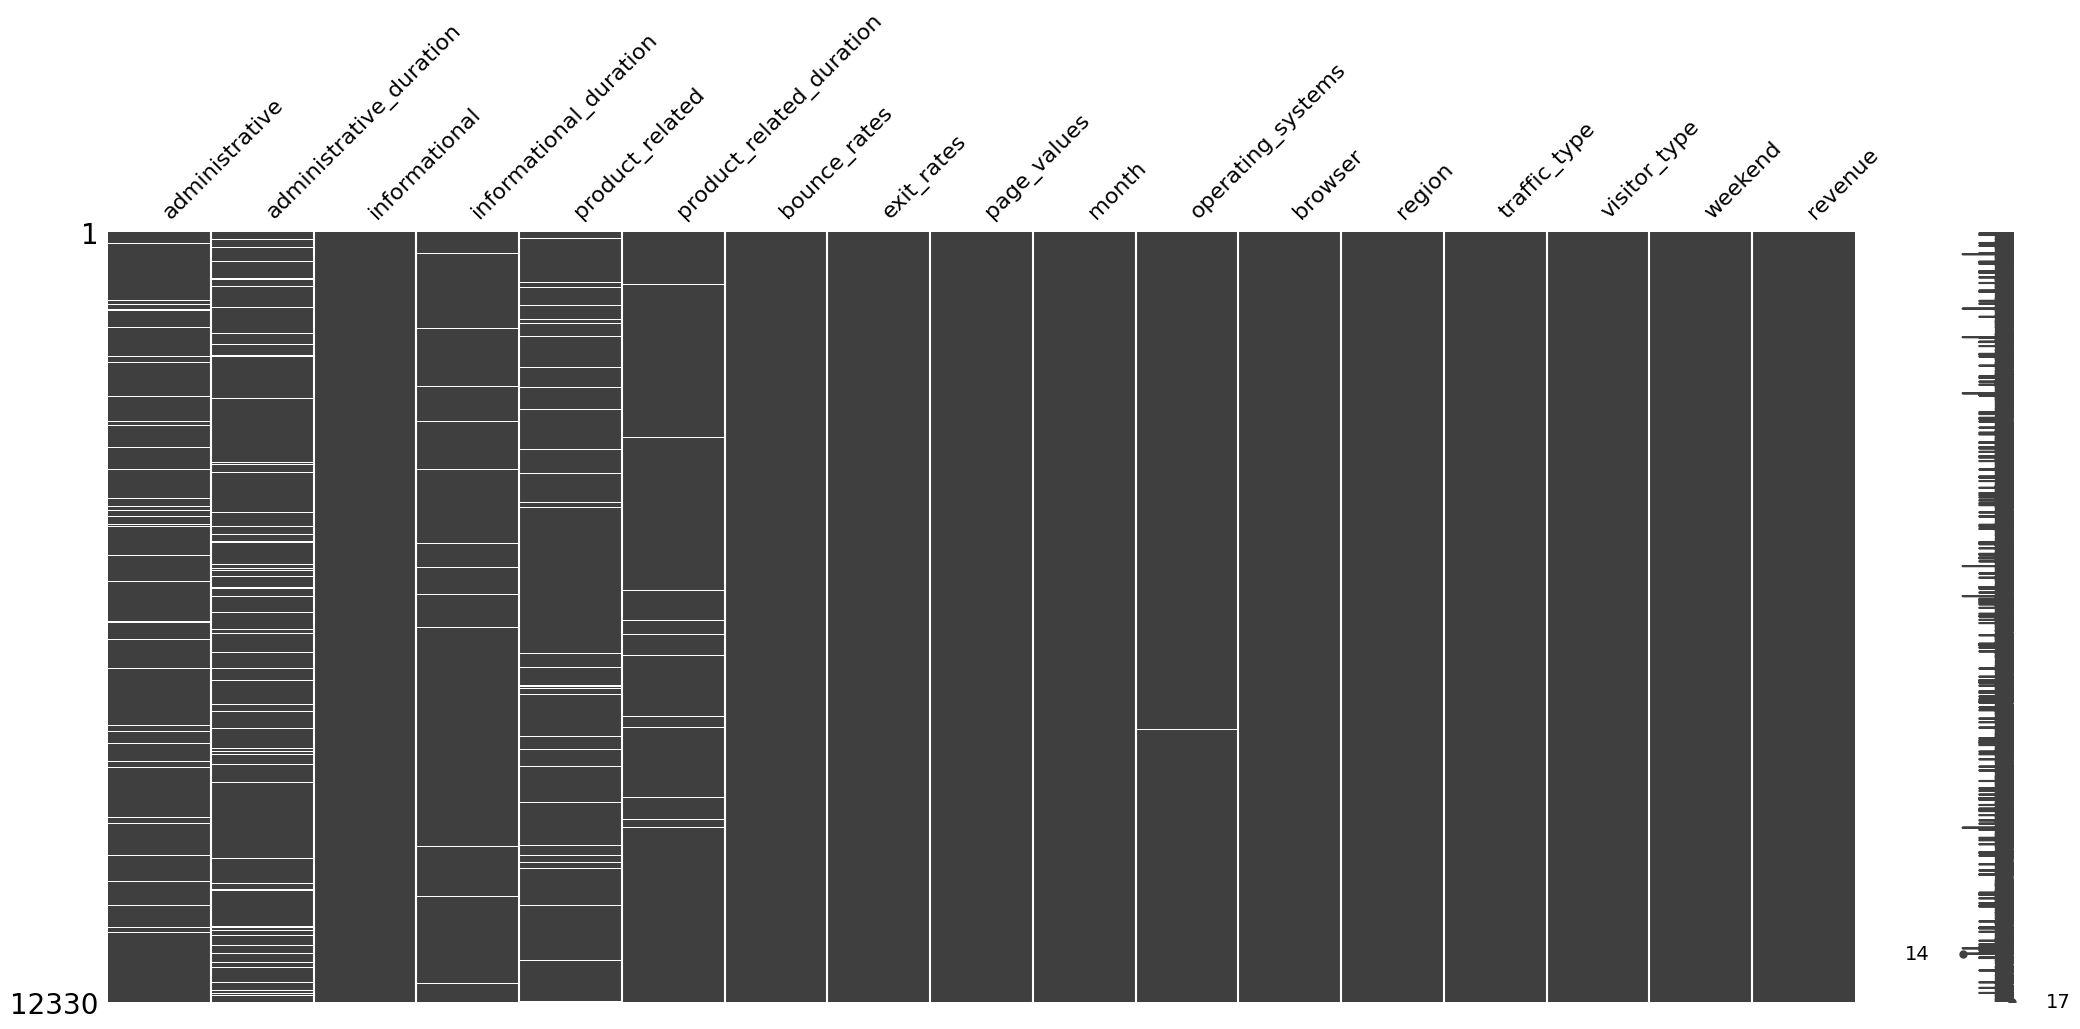

In [5]:
# Visualise missing values
nulls_plot = msno.matrix(customer_activity_df)
nulls_plot

In [6]:
info_extractor.show_distinct_values(['administrative','administrative_duration','browser','operating_systems'])
print('\n', info_extractor.count_distinct_values())
print("\nThe different regions in the dataset, and the number of records for each are: ")
print(customer_activity_df['visitor_type'].value_counts())

Unique values in administrative: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 23. 24. nan]
Unique values in administrative_duration: [0.00000000e+00 3.33333300e-02 5.00000000e-02 ... 2.13711274e+03
 2.15500000e+03            nan]
Unique values in browser: ['Android' 'Google Chrome' 'Internet Explorer' 'Microsoft Edge'
 'Mozilla Firefox' 'Opera' 'QQ' 'Safari' 'Samsung Internet'
 'Sogou Explorer' 'UC Browser' 'Undetermined' 'Yandex']
Unique values in operating_systems: ['Android' 'Windows' 'MACOS' 'ChromeOS' 'iOS' 'Ubuntu' nan 'Other']

                           distinct_values_count
column                                         
administrative                               24
administrative_duration                    3357
informational                                13
informational_duration                     1280
product_related                             296
product_related_duration                   3494
bounce_rates                 

### **Data Preprocessing**

In [7]:
transformer = DataTransform(customer_activity_df)

In [8]:
transformed_df = transformer.convert_month_to_period('month')
transformed_df = transformer.convert_columns(['weekend','revenue'],'int')
transformed_df = transformer.convert_columns(['browser','region','traffic_type','operating_systems','visitor_type'],'categorical')
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   administrative            11760 non-null  float64  
 1   administrative_duration   11418 non-null  float64  
 2   informational             12330 non-null  int64    
 3   informational_duration    11994 non-null  float64  
 4   product_related           11751 non-null  float64  
 5   product_related_duration  12129 non-null  float64  
 6   bounce_rates              12330 non-null  float64  
 7   exit_rates                12330 non-null  float64  
 8   page_values               12330 non-null  float64  
 9   month                     12330 non-null  period[M]
 10  operating_systems         12319 non-null  category 
 11  browser                   12330 non-null  category 
 12  region                    12330 non-null  category 
 13  traffic_type              12330

Determine which columns should be dropped

DROP ROWS HERE:
So far all missing values are: 
- OS: dropna x11 rows - DONE
- browser - undetermined only 2 - drop rows dropna? NOT YET
- admin and prod duration rows where the respective task is missing (Missing at Random)

DROP THESE COLUMNS:


### Null values in 'operating_systems' column

In [9]:

# First drop rows for missing values in the operating_systems column, they constitute < 1 % of values
cleaned_df = transformed_df.dropna(subset=["operating_systems"])

### Drop rows from 'OD': 'Undetermined' and 'Visitor_Type': 'Other'

In [10]:
# NOTE You could have left these in if you liked as it could be useful data but totally fair assessment to drop it as well. Just something to point out. 
# Would really depend on what question was needing answered. 
cleaned_df = cleaned_df[(cleaned_df['browser'] != 'Undetermined') & (cleaned_df['visitor_type'] != 'Other')]
info_extractor = DataFrameInfo(cleaned_df)
info_extractor.count_distinct_values()

,distinct_values_count
column,
administrative,24
administrative_duration,3345
informational,13
informational_duration,1278
product_related,296
product_related_duration,3490
bounce_rates,613
exit_rates,164
page_values,739


In [11]:
info_extractor = DataFrameInfo(cleaned_df)
transformer = DataTransform(cleaned_df)
stats_tests = StatisticalTests(cleaned_df)
plotter = Plotter(cleaned_df)

### Missing values in categorical columns: 'administrative' column

Categorical variable: numbers encode different administrative tasks.
Therefore, as long as it is MCAR, we should impute with the mode. 

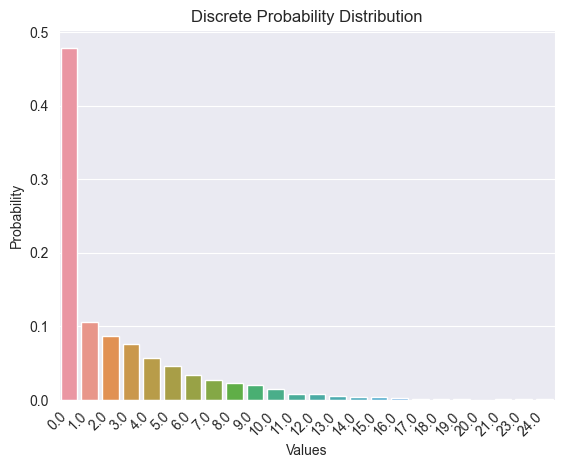

In [12]:
plotter.discrete_probability_distribution('administrative')

In [13]:
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]
categorical_features = info_extractor.extract_categorical_features(numeric_features)
stats_tests.chi_square_test("administrative", categorical_features)

Chi-square test for missing values in administrative against administrative column: 
p-value = 0.0: Significant


0.0

In [14]:
cleaned_df = transformer.impute_nulls_with_mode(["administrative"])

### Missing values in categorical columns: 'product_related'

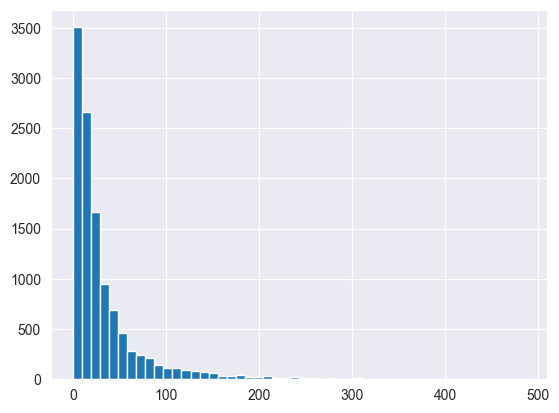

In [15]:
cleaned_df['product_related'].hist(bins = 50)
cleaned_df = transformer.impute_nulls_with_mode(["product_related"])

### Missing values in 'administrative_duration' column

Continuous variable. Potentially MCAR, or MAR if values missing depend on the missingness of values in the column 'administrative'. Let's check the correlation of both variables first, then we can perform a chi-square test

The mode of the distribution is 0.0
The mean of the distribution is 84.64388205214482
The median of the distribution is 6.6


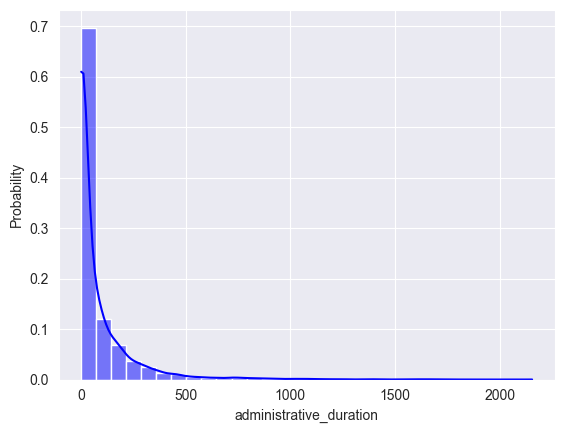

In [16]:
plotter.continuous_probability_distribution('administrative_duration')

In [17]:
cleaned_df = transformer.impute_nulls_with_median(["administrative_duration"])

### Missing values in 'informational_duration' column

The mode of the distribution is 0.0
The mean of the distribution is 34.55805728419409
The median of the distribution is 0.0


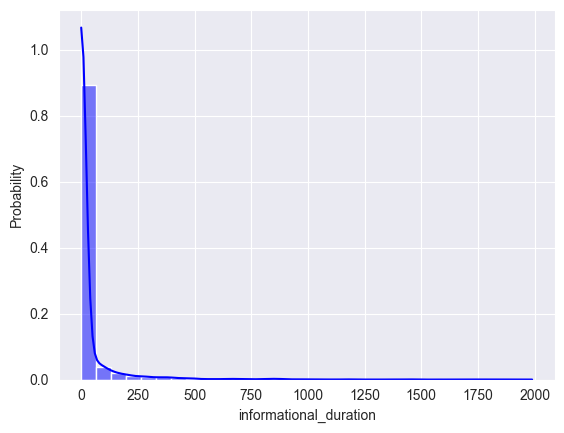

In [18]:
plotter.continuous_probability_distribution('informational_duration')

In [19]:
transformed_df = transformer.impute_nulls_with_median(['informational_duration'])

### Missing values in 'product_related_duration'

The mode of the distribution is 0.0
The mean of the distribution is 1195.8714309428951
The median of the distribution is 589.0


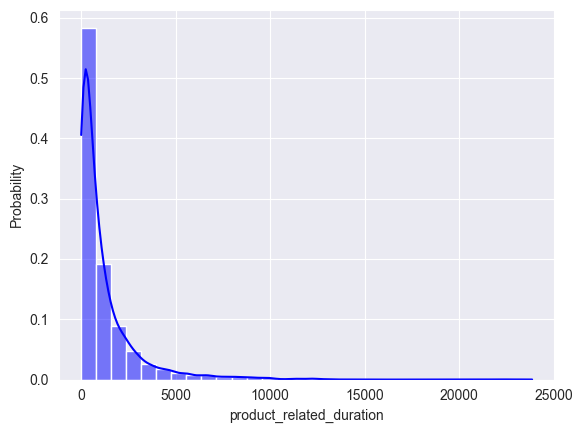

In [20]:
plotter.continuous_probability_distribution('product_related_duration')

In [21]:
cleaned_df = transformer.impute_nulls_with_median(['product_related_duration'])

Now we can check if all nulls have been dropped or imputed:

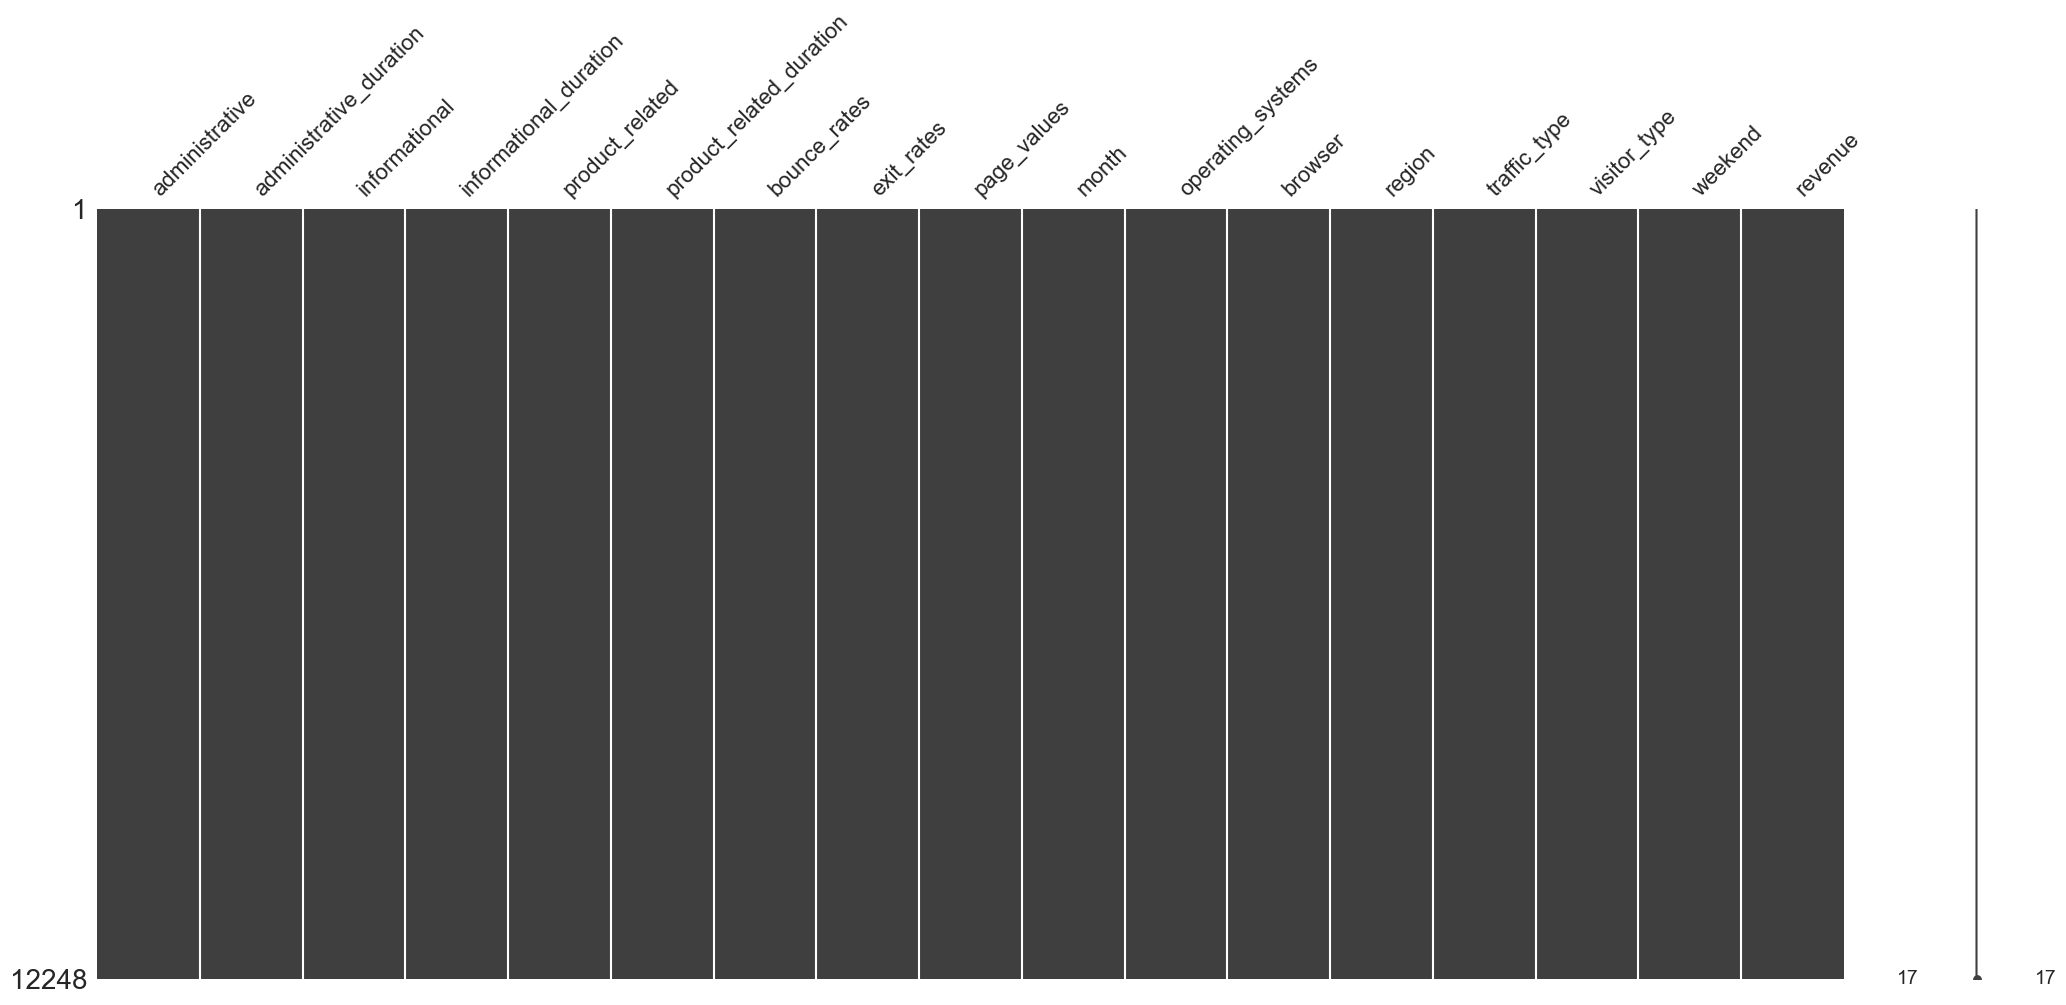

In [22]:
plotter = Plotter(cleaned_df)
plotter.nulls_dataframe_plot()

## Checking the distributions

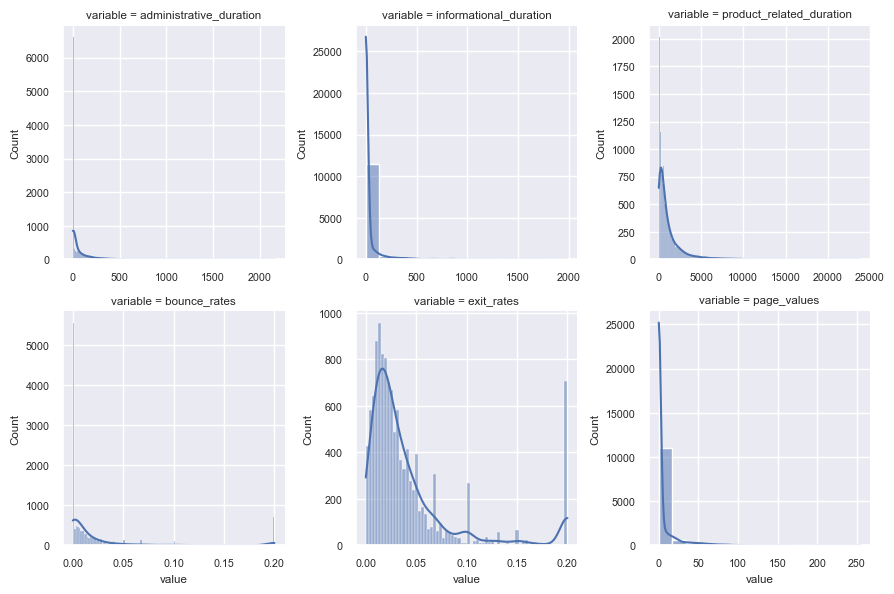

In [23]:
# NOTE Nice annotations on the graphs
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]

plotter.numeric_distributions_grid(numeric_features)

### Correcting skewed columns
1. **Column: 'bounce_rates'**

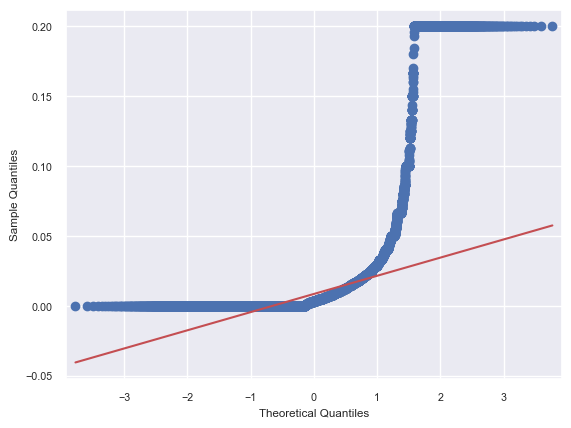

In [24]:
plotter.qqplot(['bounce_rates'])

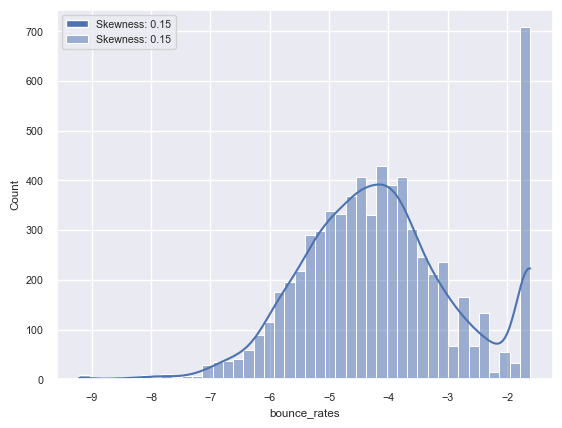

In [25]:
#plotter.plot_log_transform(['bounce_rates'])
plotter.plot_log_transform('bounce_rates')

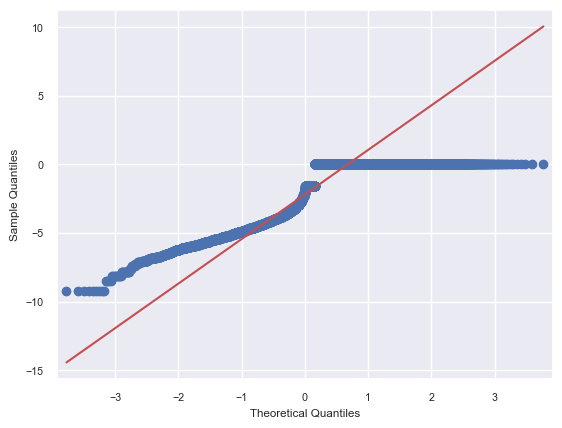

In [26]:
transformer = DataTransform(cleaned_df)
cleaned_no_skew_df = transformer.log_transform(['bounce_rates'])
plotter = Plotter(cleaned_no_skew_df)
plotter.qqplot(['bounce_rates'])

2. Column: ***"exit_rates"***

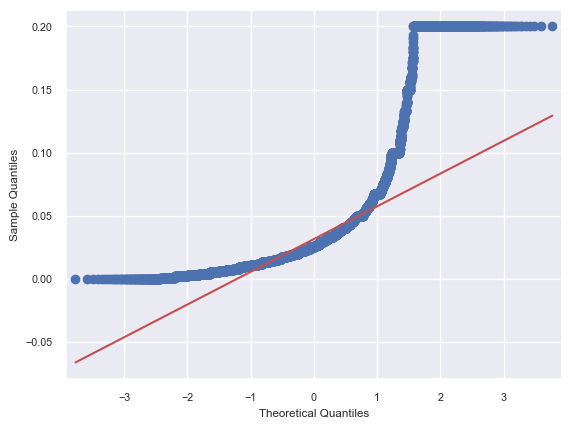

In [27]:
plotter.qqplot(['exit_rates'])

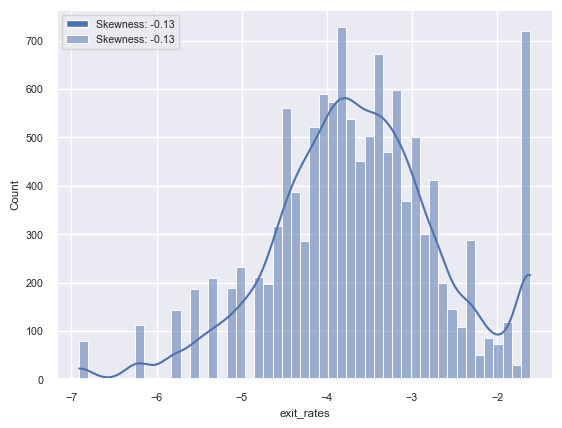

In [28]:
plotter.plot_log_transform('exit_rates')

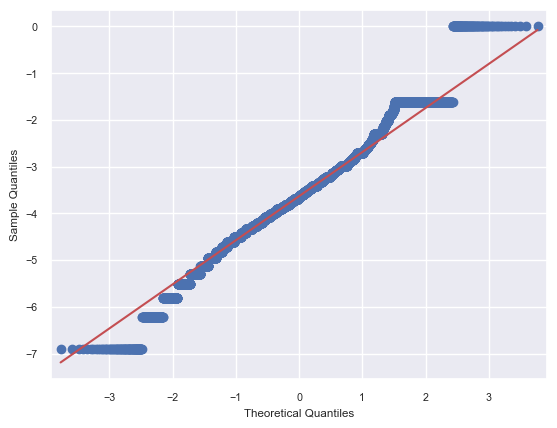

In [29]:
transformer = DataTransform(cleaned_df)
cleaned_no_skew_df = transformer.log_transform(['exit_rates'])
plotter = Plotter(cleaned_no_skew_df)
plotter.qqplot(['exit_rates'])

3. **Column: "product_related_duration"**

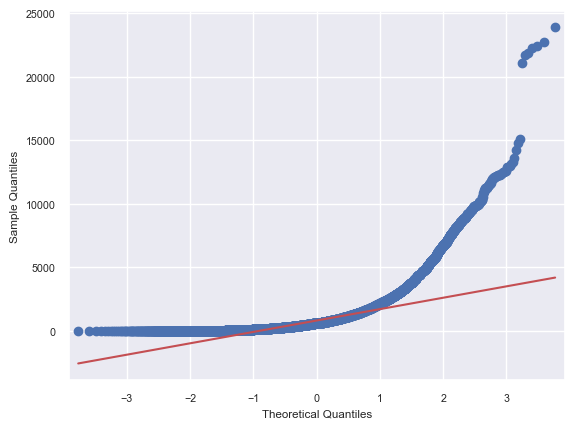

In [30]:
plotter.qqplot(['product_related_duration'])

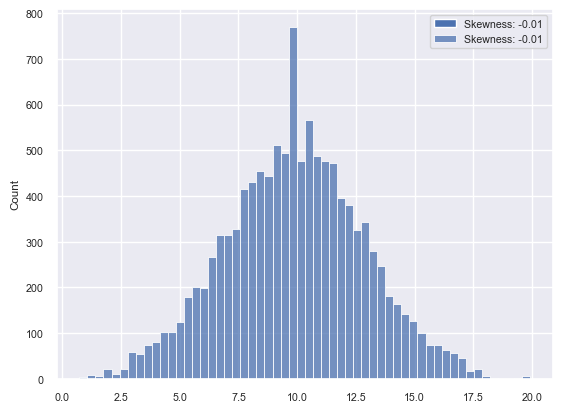

In [31]:
plotter.plot_yeo_johnson_transform('product_related_duration')

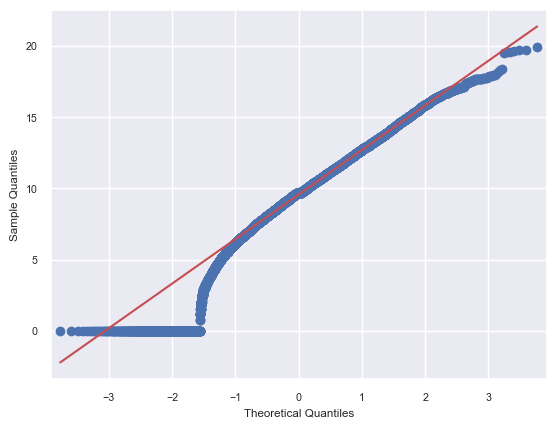

In [32]:
transformer = DataTransform(cleaned_no_skew_df)
cleaned_no_skew_df = transformer.yeo_johnson_transform(['product_related_duration'])
plotter = Plotter(cleaned_no_skew_df)
plotter.qqplot(['product_related_duration'])

4. Column: **"administrative_duration"**

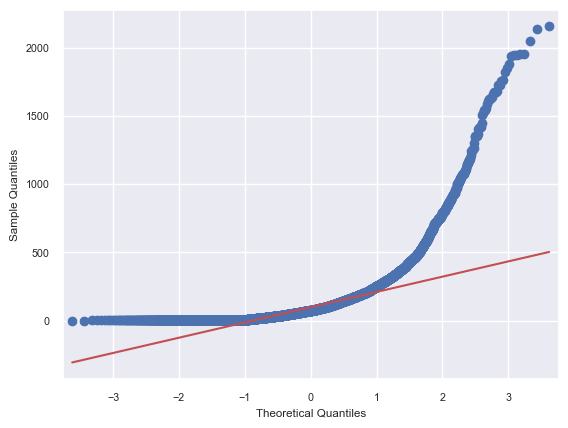

In [33]:
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['administrative_duration'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['administrative_duration'])

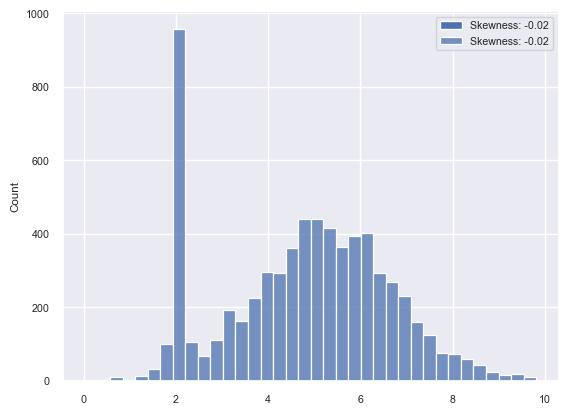

In [34]:
plotter.plot_yeo_johnson_transform('administrative_duration')

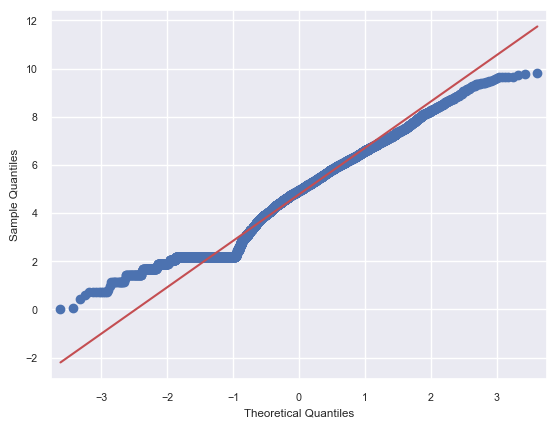

In [35]:
transformer = DataTransform(cleaned_no_skew_df)
cleaned_no_skew_df = transformer.yeo_johnson_transform(['administrative_duration'])
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['administrative_duration'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['administrative_duration'])

5. Column: **"informational_duration"**

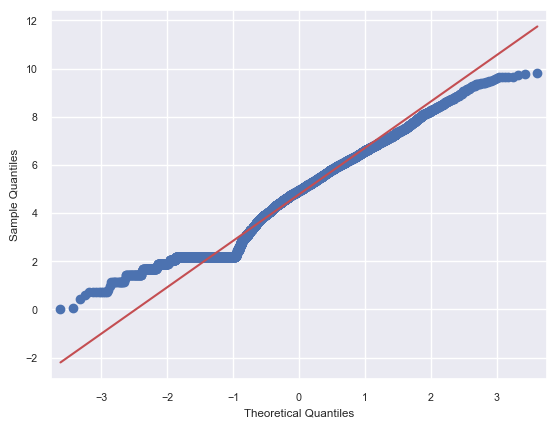

In [36]:
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['administrative_duration'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['administrative_duration'])

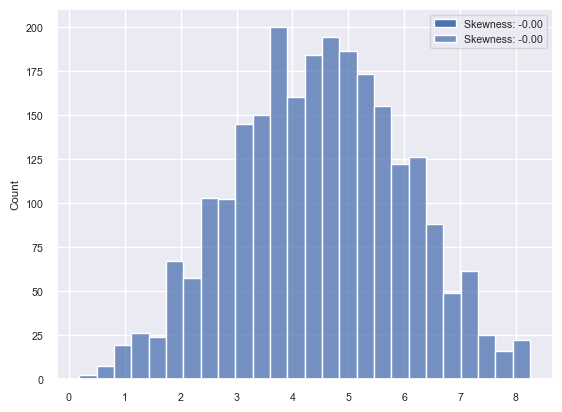

In [37]:
plotter.plot_yeo_johnson_transform('informational_duration')

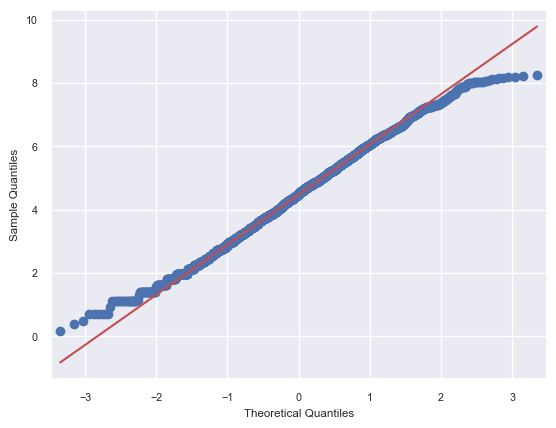

In [38]:
transformer = DataTransform(cleaned_no_skew_df)
cleaned_no_skew_df = transformer.yeo_johnson_transform(['informational_duration'])
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['informational_duration'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['informational_duration'])

6. Column: **"page_values"**

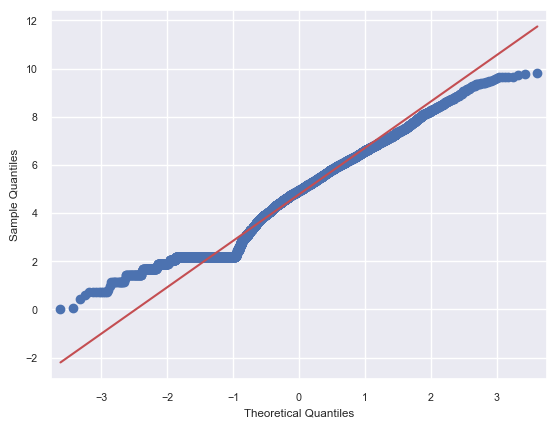

In [39]:
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['administrative_duration'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['administrative_duration'])

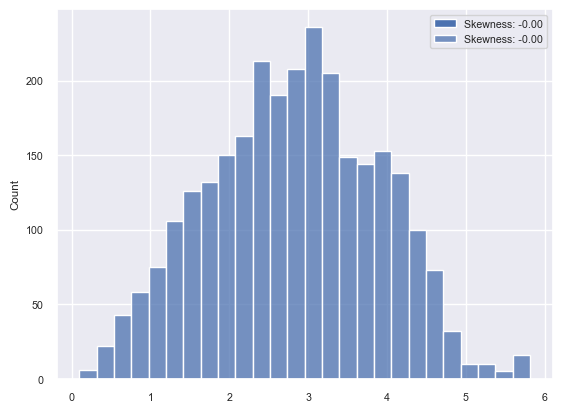

In [40]:
plotter.plot_yeo_johnson_transform('page_values')

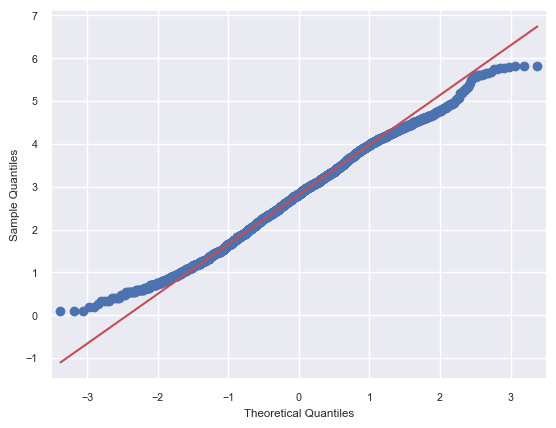

In [41]:
transformer = DataTransform(cleaned_no_skew_df)
cleaned_no_skew_df = transformer.yeo_johnson_transform(['page_values'])
nonzero_values = cleaned_no_skew_df[cleaned_no_skew_df['page_values'] != 0]
plotter_test = Plotter(nonzero_values)
plotter_test.qqplot(['page_values'])

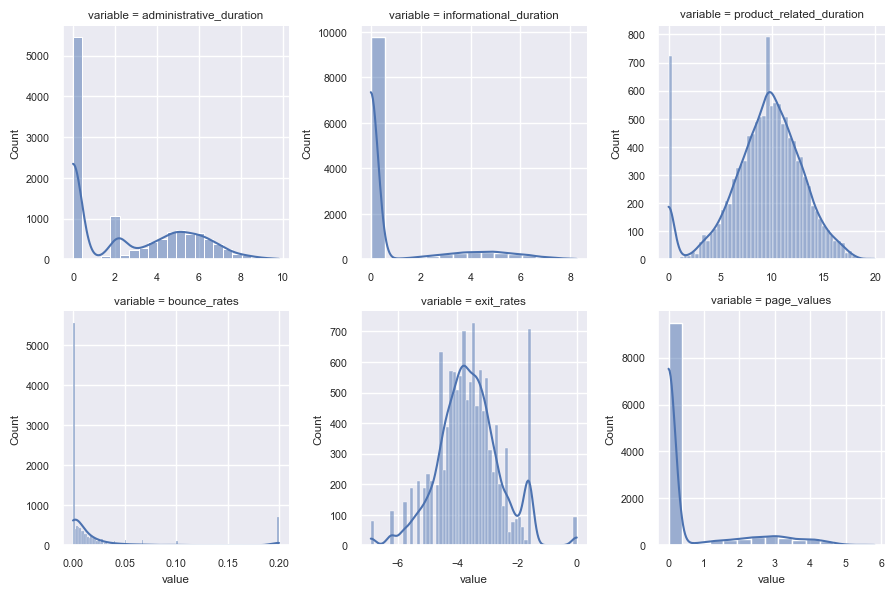

In [42]:
plotter = Plotter(cleaned_no_skew_df)
plotter.numeric_distributions_grid(numeric_features)

## Checking the categorical distributions

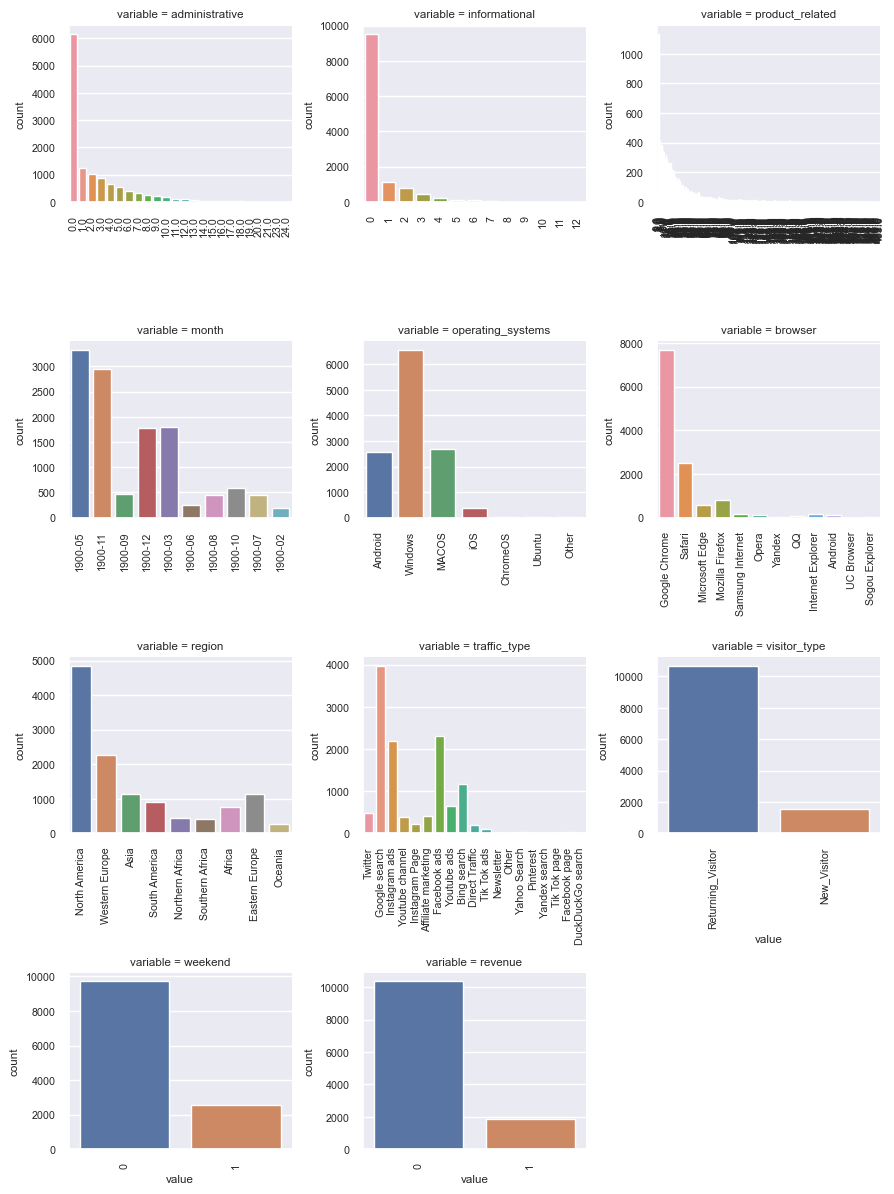

In [43]:
# TODO Don't know what happend to your product_related graph here it didn't seem to render correctly. 
categorical_features = info_extractor.extract_categorical_features(numeric_features)
plotter.count_plots_grid(categorical_features)

# Correlations in the dataframe

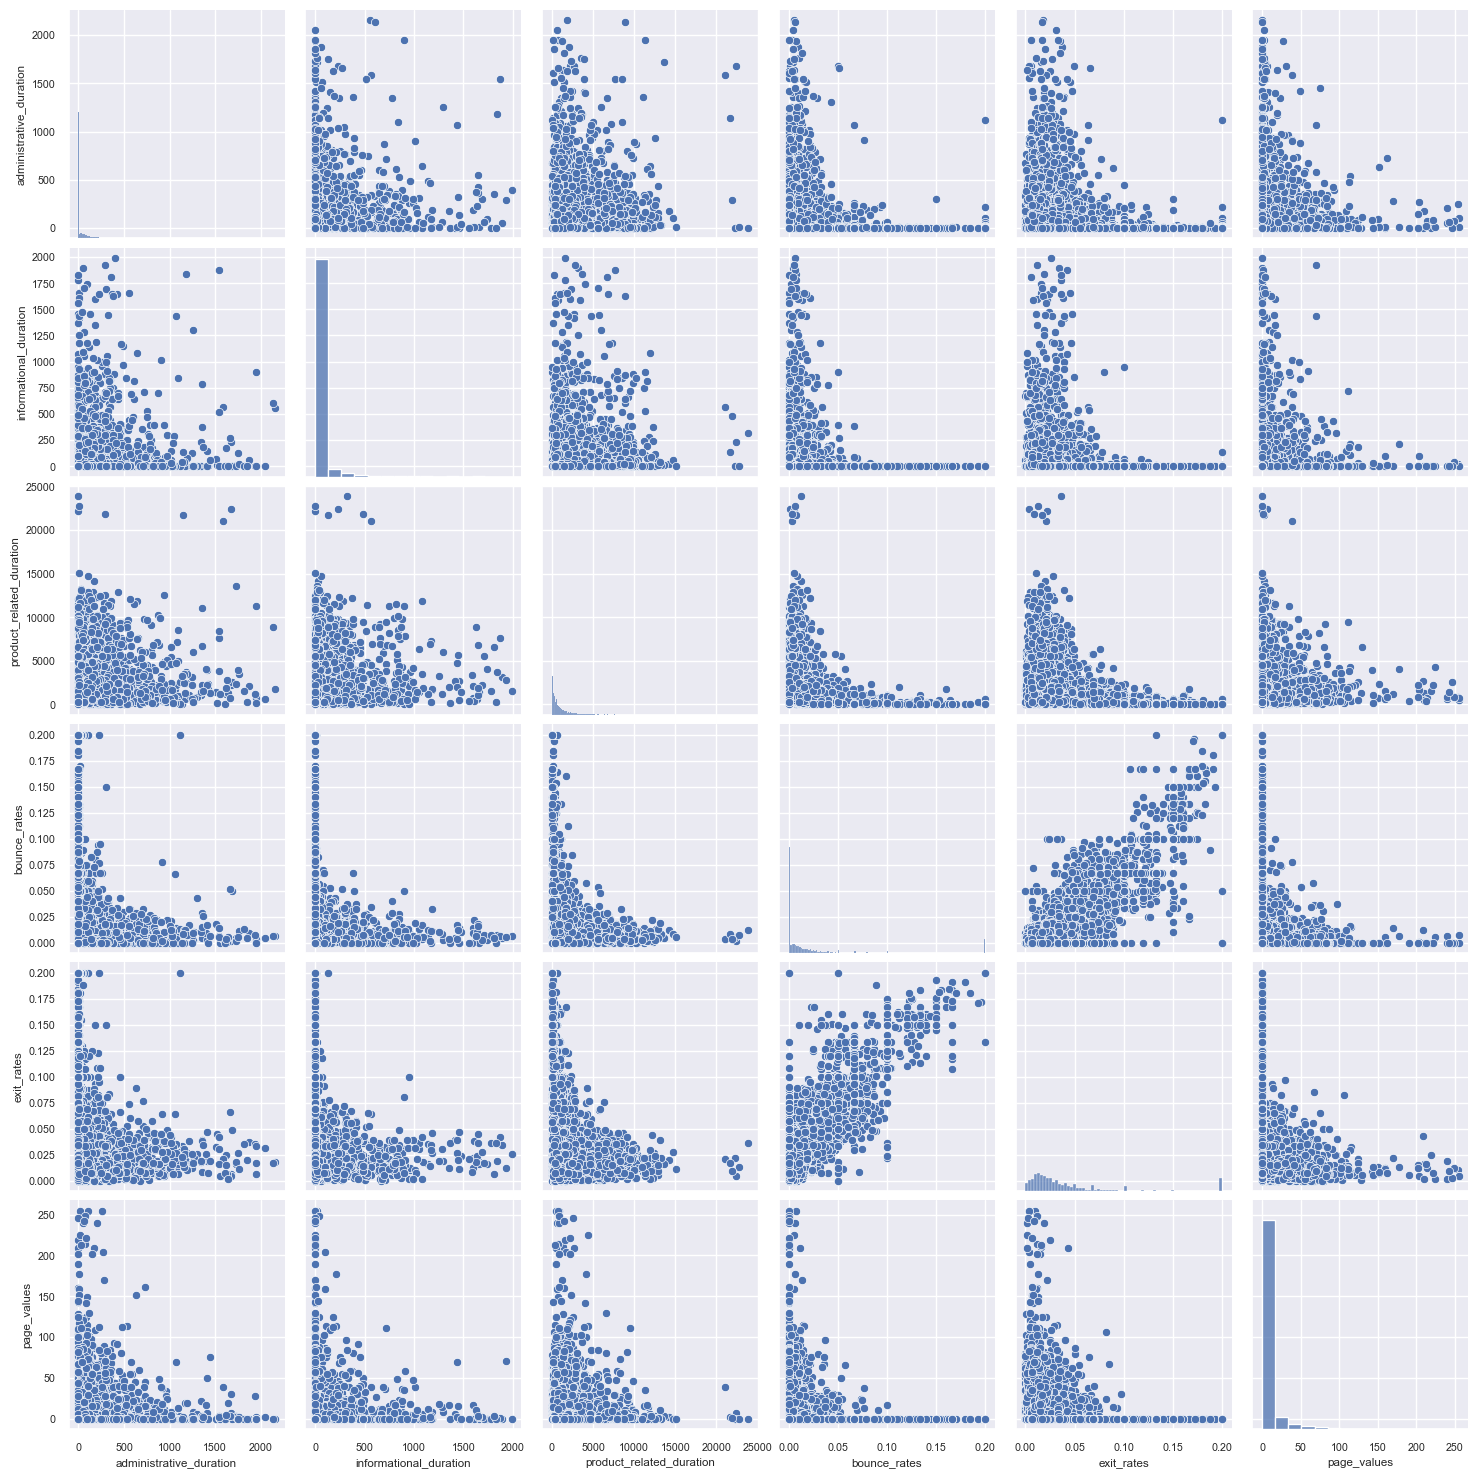

In [44]:
plotter_1 = Plotter(cleaned_df)
plotter_1.pair_correlations_grid(numeric_features)

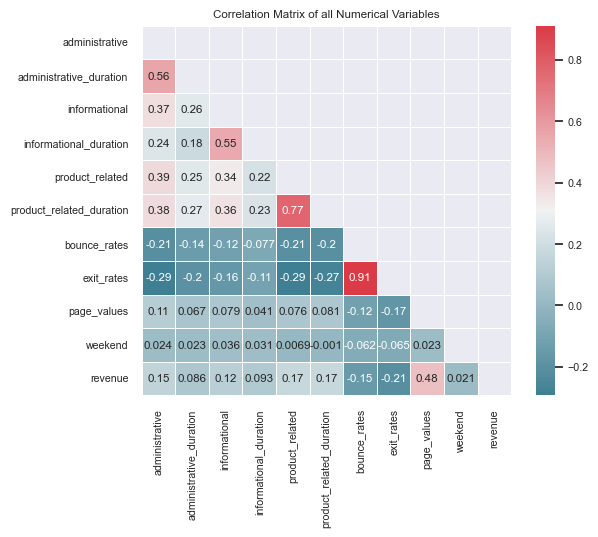

In [45]:
plotter_1.correlation_matrix_df()

### Drop exit rates column

This column is heavily correlated with bounce rates.

In [46]:
# NOTE To decide which column to drop between exit rates and bounce rate. What you could do is compare the VIF (Variance inflation factor) of these columns against all remaining columns.
# Whichever column is contributing the most to the VIF factor you can decide to drop. 
column_to_drop = 'exit_rates'
cleaned_no_skew_df.drop(column_to_drop, axis=1, inplace=True)
cleaned_no_skew_df.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.000000,0,0.0,4.0,0.000000,0.2000,0.000000,1900-05,Android,Google Chrome,North America,Twitter,Returning_Visitor,0,0
1,0.0,0.000000,0,0.0,26.0,10.567129,0.0000,0.000000,1900-11,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,1,0
2,2.0,5.327479,0,0.0,19.0,8.681097,0.0396,0.000000,1900-09,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,0,0
3,0.0,0.000000,0,0.0,20.0,11.729320,0.0248,1.038731,1900-12,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,0,1
4,0.0,0.000000,0,0.0,33.0,10.040563,0.0141,0.000000,1900-05,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,0,0


### Detecting and removing outliers

- CATEGORICAL VARIABLES: First, we can check for outliers in the categorical variables by inspecting the type of values and also by plotting their frequency distributions (see above). If a category is very infrequent, it could be considered an outlier. I have decided not to remove any values or categories here. I will take care of any necessary filtering and groupings in the analysis.

- NUMERICAL VARIABLES: I have done some quick check with IQR, but I decided to leave outlier checking during the analysis of the data.


In [47]:
# Good analysis of the categorical columns
# NOTE Absolutely fine to leave removal of the outliers if you feel their values are true outliers. 
col = ['product_related_duration', 'exit_rates','page_values']
stats_test = StatisticalTests(cleaned_no_skew_df)
stats_tests.IQR_outliers(col)


Results for product_related_duration column:
Q1 (25th percentile): 195.0
Q3 (75th percentile): 1430.0
IQR: 1235.0
Outliers:
(1024, 17)

Results for exit_rates column:
Q1 (25th percentile): 0.014
Q3 (75th percentile): 0.049
IQR: 0.035
Outliers:
(1080, 17)

Results for page_values column:
Q1 (25th percentile): 0.0
Q3 (75th percentile): 0.0
IQR: 0.0
Outliers:
(2763, 17)


## Download processed dataset to local folder as .csv

In [48]:
#preprocessed_data = cleaned_no_skew_df.copy()
#preprocessed_data.to_csv("preprocessed_data.csv")
#preprocessed_data_skewed = cleaned_df.copy()
#preprocessed_data_skewed.to_csv("preprocessed_skewed_data.csv")